## Imports and setting filepaths based on config

In [88]:
from pathlib import Path
import sys
import math
from typing import List, Tuple

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import dotenv_values
import scipy

import echonet

config = dotenv_values(".env")

# Just some types for us to use in type hints to make dev easier
Point = List[np.intp]
Box = Tuple[Point, Point, Point, Point]
Rectangle = Tuple[Point, Tuple[float, float], float] # [centre, (width, height), angle]

# Directories containing both original and flipped segmentation masks
LEFT_SEGMENTATION_DIR = Path(config["LEFT_SEGMENT_DIR"]) # e.g. LEFT_SEGMENT_DIR="output/segmentation/all-patients"
LEFT_SEGMENTATION_MASK_DIR = LEFT_SEGMENTATION_DIR / "segmentation_masks" # remember that you have to have run the modified segmentation.py to get this segmentations sub-directory!
FLIPPED_SEGMENTATION_DIR = Path(config["FLIPPED_SEGMENT_DIR"]) # e.g. FLIPPED_SEGMENT_DIR="output/segmentation/flipped"
FLIPPED_SEGMENTATION_MASK_DIR = FLIPPED_SEGMENTATION_DIR / "segmentation_masks"

ECHONET_VIDEO_DIR = Path(config["ECHONET_VIDEO_DIR"]) # e.g. ECHONET_VIDEO_DIR="/home/lex/data/echonet-data/Videos"

# Can assign these colours to numpy arrays so long as the colours are stored in
# the last axis of the target array (e.g. image.shape =(112, 112, 3), but not
# image.shape = (3, 112, 112)). 
# Just do image[y_vals, x_vals] = MAGENTA
# IMPORTANT: if using within an *opencv* function, you'll want to do 
# COLOUR.tolist() to convert these to python primitives, else opencv complains about
# datatypes
# Note also that these are BGR, not RGB, since that's what opencv prefers BGR for historical reasons!
RED = np.array([0, 0, 255])
GREEN = np.array([0, 255, 0])
BLUE = np.array([255, 0, 0])
ORANGE = np.array([0, 165, 255])
LIGHT_GREY = np.array([211, 211, 211])
MAGENTA = np.array([255, 0, 255])
YELLOW = np.array([0, 255, 255])
WHITE = np.array([255, 255, 255])
BLACK = np.array([0, 0, 0])

## Utility functions for us

In [89]:
def get_heights(mask: np.ndarray) -> List[int]:
    """
    Returns array of heights of mask for each frame! Height is determined based
    on the highest and lowest (in terms of y values) pixels that are True in the
    given mask.
    """
    frame_indices, row_indices = np.where(mask.any(axis=1)==True)

    heights = []
    for frame_index in range(mask.shape[0]):
        this_frame = frame_indices == frame_index

        if len(row_indices[this_frame]) == 0:
            # print(f"Frame #{frame_index} appears to have no segmentations? Treating this as zero height...")
            heights.append(0)
            continue

        min_row, max_row = (min(row_indices[this_frame]), max(row_indices[this_frame]))
        height = max_row - min_row
        heights.append(height)

    heights = np.array(heights)
    return heights


def get_angle(rect: Rectangle) -> float:
    """
    Converts the angle returned by opencv for a rotated rectangle into a more
    reliable one that doesn't require you to know which sides correspond to 
    "height" and which correspond to "width".

    Returns
    -------
    angle: float
        Angle in degrees in the range of (-90, 90).
    """
    _, (width, height), angle = rect
    if width < height:
        return 0 - angle
    elif height <= width:
        return 90 - angle


BOTTOM_RIGHT = 0
BOTTOM_LEFT = 1
TOP_RIGHT = 2
TOP_LEFT = 3

def find_corner(rect: Rectangle, which: int) -> Point:
    """
    Returns the coordinates of either the "bottom-right", "bottom-left", 
    "top-left", or "top-right" corner of the given (possible rotated) rectangle.
    The specific corner is chosen with the `which` parameter.

    Note these corner names are a little ambiguous, but were defined based on
    what was most applicable to our needs.
    """
    angle = get_angle(rect)
    box = np.intp(cv2.boxPoints(rect))

    # Critical angle regions are: [-90, -45), [-45, 0], (0, 45), [45, 90) ?
    if (-90 <= angle < -45) or (0 < angle < 45):
        if which == BOTTOM_LEFT:
            return box[3]
        elif which == TOP_LEFT:
            return box[0]
        elif which == TOP_RIGHT:
            return box[1]
        elif which == BOTTOM_RIGHT:
            return box[2]
    elif (-45 <= angle <= 0) or (45 <= angle <= 90):
        if which == BOTTOM_LEFT:
            return box[0]
        elif which == TOP_LEFT:
            return box[1]
        elif which == TOP_RIGHT:
            return box[2]
        elif which == BOTTOM_RIGHT:
            return box[3]


def mask_to_image(mask: np.ndarray, max_val: int = 255) -> np.ndarray:
    """
    Converts a boolean mask array to a pure black and white image. Useful if
    you start with a mask but then want to find contours and perform other image
    analysis on that mask    
    """
    return mask.astype(np.uint8) * max_val


def image_to_mask(image: np.ndarray, threshold: int = 1) -> np.ndarray:
    """
    Converts a black and white image to a boolean mask, selecting every pixel 
    whose intensity is **greater than or equal to the threshold**
    """
    return image >= threshold


def extrapolate_line(p1: Point, p2: Point, frame_height: int, frame_width: int) -> List[Point]:
    """
    Extends a line between the given pair of points for all given x values and
    returns the list of points on this line.
    
    This clips the points for you in case any of the given x values correspond to
    y values outside of the image's borders.
    """
    # Just to be safe, make sure points are in ascending order of x (unless 
    # vertically alligned)
    if p2[0] < p1[0]:
        p1, p2 = p2, p1

    x1, y1 = p1
    x2, y2 = p2

    # Vertical line is special case
    if x1 == x2:
        # Vertical lines are a special case
        ys = np.arange(frame_height)
        xs = np.ones(ys.shape, dtype=np.intp) * x1
    else:
        gradient = (y2 - y1) / (x2 - x1)
        y_intercept = y1 - gradient * x1
        
        # Whether the straight line will be steep or not. If it *is* steep, then that
        # means that a single x value can correspond to multiply y values, due to
        # pixellated nature of the line, and vice versa if it is *not* steep. We
        # therefore need to treat the two steepness cases separately to ensure a
        # fully continuous line.
        is_steep = abs(y2 - y1) > abs(x2 - x1)
        if is_steep:
            # Start with all y values, and determine matching xs
            ys = np.arange(frame_height)
            #    y = mx + c
            # => x = (y - c) / m
            xs = (ys - y_intercept) / gradient
        else:
            # Start with all x values, and determine matching ys
            xs = np.arange(frame_width)
            ys = gradient * xs + y_intercept
    
    # Make sure coordinates are all corect type for opencv indexing
    xs = np.intp(xs)
    ys = np.intp(ys)
    points = list(zip(xs, ys))
    return points


def get_min_area_rect(image: np.ndarray) -> Rectangle:
    """
    Finds the largest contour in the given image, and returns the minimum area
    rectangle that bounds it.

    Returns
    -------
    ((centre_x, centre_y), (width, height), angle)
    """
    contours, hierarchy = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None

    # Assume we're only interested in max area contour
    areas = [cv2.contourArea(cnt) for cnt in contours]
    max_index = np.argmax(areas)
    biggest_contour = contours[max_index]

    min_area_rect = cv2.minAreaRect(biggest_contour)

    centre, (width, height), angle = min_area_rect
    if angle == 90:
        # Rotate counterclockwise by 90 degrees if angle is 90 degrees
        min_area_rect = (centre, (height, width), 0)

    return min_area_rect


def get_min_area_box(image: np.ndarray) -> Box:
    """
    Similar to get_min_area_rect(), but instead returns the coordinates of the
    box's four corners.
    """
    min_area_rect = get_min_area_rect(image)
    if min_area_rect is None:
        return None
    box = np.intp(cv2.boxPoints(min_area_rect))
    
    return box


def perpendicular_distance_to_line(line: List[List[int]], point: List[int]) -> float:
    """
    Returns the perpendicular distance from a straight line to a given point.

    Parameters
    ----------
    line: List[List[int]]
        `line` is a *pair* of points, where each point contains a single x and y
        value.
    point: List[int]
        A pair of x and y values.
    """
    (x1, y1), (x2, y2) = line
    x3, y3 = point

    if x2 == x1:
        return abs(x1 - x3)

    m = (y2 -y1) / (x2 - x1)
    a = -1
    b = 1 / m
    c = x1 - y1 / m

    d = abs(a * x3 + b * y3 + c) / math.sqrt(a**2 + b**2)
    return d


def crop_mask_with_line(mask: np.ndarray, line: List[Point], below=False, above=False, left=False, right=False):
    """
    Sets all pixels to some side(s) of the given line to False in the given 
    mask, effectively cropping the mask with an arbitrary line.

    Note that the given line can technically have points that are out of bounds
    of the frame. This is actually needed so we can crop based on particularly
    steep lines (e.g. the LV's septum border, which likely only takes up a few
    x values in the actual frame). 

    This modifies the given `mask` in-place.
    """
    mask_height, mask_width = mask.shape

    for x, y in line:
        y_is_valid = (0 <= y < mask_height)
        x_is_valid = (0 <= x < mask_width)

        if below and x_is_valid:
            y = min(y, mask_height-1)
            mask[y:, x] = False
        if above and x_is_valid:
            y = max(y, 0)
            mask[:y, x] = False
        if left and y_is_valid:
            x = min(x, mask_width-1)
            mask[y, :x] = False
        if right and y_is_valid:
            x = max(x, 0)
            mask[y, x:] = False


def crop_line_to_frame(line: List[Point], frame_height: int, frame_width: int) -> List[Point]:
    """
    Returns a subset of the given `line` that fits within the given frame 
    dimensions. This is useful if you have a line that potentially goes beyond 
    the frame, and you want to show that line using opencv (which will complain
    about index errors if any given points are out of bounds).
    """
    # We could probs use cv2.clipLine(), but that only returns the two endpoints,
    # so we'd still have to find all points in between anyway!
    cropped_line = []
    for point in line:
        x, y = point
        if (0 <= x < frame_width) and (0 <= y < frame_height):
            cropped_line.append(point)

    return cropped_line


def clip_and_draw_line(frame: np.ndarray, line: List[Point], colour: Tuple[int, int, int]):
    """
    Helper function to draw the given line on the given frame, making sure to clip
    the line to the frame to avoid any out-of-bounds errors.
    """
    frame_height, frame_width, _ = frame.shape
    img_rect = (0, 0, frame_width, frame_height)
    in_bounds, point1, point2 = cv2.clipLine(img_rect, line[0], line[-1])
    
    cv2.line(frame, point1, point2, colour)


def is_a2c(left_segmentation_masks, right_segmentation_masks):
    intersection = left_segmentation_masks & right_segmentation_masks
    intersection_counts = intersection.sum(axis=(1, 2))
    union = left_segmentation_masks | right_segmentation_masks
    union_counts = union.sum(axis=(1, 2))
    ious = intersection_counts / union_counts
    
    return np.mean(ious) > 0.5

## Load sample echonet video and its corresponding raw left and right segmentations

In [90]:
# Reload here so we can just change the VIDEONAME in .env without having to 
# go back and rerun top cell
config = dotenv_values(".env")
VIDEONAME = config["VIDEONAME"] # e.g. VIDEONAME="0X1DB488AC3583E3D6"

LEFT_SEGMENTATION_MASK_FP = LEFT_SEGMENTATION_MASK_DIR / f"{VIDEONAME}.npy"
FLIPPED_SEGMENTATION_MASK_FP = FLIPPED_SEGMENTATION_MASK_DIR / f"{VIDEONAME}.npy"
ECHONET_VIDEO_FP = ECHONET_VIDEO_DIR / f"{VIDEONAME}.avi"

left_segmentation_masks = np.load(LEFT_SEGMENTATION_MASK_FP)
flipped_segmentation_masks = np.load(FLIPPED_SEGMENTATION_MASK_FP)
right_segmentation_masks = np.flip(flipped_segmentation_masks, -1) # Flip back to original orientation
# Remove any pixels in right segmentation that are already in left segmentation
# right_segmentation_masks = right_segmentation_masks & ~left_segmentation_masks

left_segmentations = mask_to_image(left_segmentation_masks)
right_segmentations = mask_to_image(right_segmentation_masks)

echonet_video = echonet.utils.loadvideo(str(ECHONET_VIDEO_FP))
echonet_video = echonet_video.transpose((1, 2, 3, 0)) # Put colour axis at end for easier colouring of pixels
num_frames, frame_height, frame_width, num_channels = echonet_video.shape

## Check if this is actually an A4C video or if it might be A2C

In [91]:
print(f"Should we be using this video? {not is_a2c(left_segmentation_masks, right_segmentation_masks)}")

Should we be using this video? True


## Define key variables related to LV
These are fine to define once and reuse over and over because we assume the LV segmentations are practically perfect, meaning we will never change them. This is in contrast to the RV segmentations, which we will regularly modify throughout this notebook.

In [92]:
# Define LV boxes and rectangles
LV_boxes = [get_min_area_box(left_segmentation) for left_segmentation in left_segmentations]
LV_rects = [get_min_area_rect(left_segmentation) for left_segmentation in left_segmentations]
LV_septum_borders = [[find_corner(rect, BOTTOM_LEFT), find_corner(rect, TOP_LEFT)] for rect in LV_rects]
LV_angles = [get_angle(rect) for rect in LV_rects]

## Trim RV segmentation based on LV bounding box
If you extend the bottom of the LV's bounding box (which should roughly be in line with the mitral valve, i.e. near-horizontal), then assume that the tricuspid valve is somewhere along that line. Therefore, any of the RV segmentation that appears *below* that line must be incorrectly including some of the RA, 

In [93]:
# Trim RV segmentations based on LV bounding box
right_segmentations = np.zeros(shape=right_segmentations.shape, dtype=right_segmentations.dtype)

valve_cutoff_points_list = []
apex_cutoff_points_list = []
LV_septum_border_cutoff_points_list = []

cutoff_x = np.intp(np.arange(0, frame_width))

for i, (LV_box, LV_rect, right_segmentation_mask) in enumerate(zip(LV_boxes, LV_rects, right_segmentation_masks)):
    top_left_LV = find_corner(LV_rect, TOP_LEFT)
    top_right_LV = find_corner(LV_rect, TOP_RIGHT)
    bottom_left_LV = find_corner(LV_rect, BOTTOM_LEFT)
    bottom_right_LV = find_corner(LV_rect, BOTTOM_RIGHT)

    # Remove any points from RV segmentation that seem to be *below* tricuspid valve (e.g. in RA)
    valve_cutoff_points = extrapolate_line(bottom_left_LV, bottom_right_LV, frame_height=frame_height, frame_width=frame_width)
    valve_cutoff_points_list.append(valve_cutoff_points)
    crop_mask_with_line(mask=right_segmentation_mask, line=valve_cutoff_points, below=True)

    # Remove any points from RV segmentation that seem to be *above* heart's apex
    apex_cutoff_points = extrapolate_line(top_left_LV, top_right_LV, frame_height=frame_height, frame_width=frame_width)
    apex_cutoff_points_list.append(apex_cutoff_points)
    crop_mask_with_line(mask=right_segmentation_mask, line=apex_cutoff_points, above=True)

    # Remove any points from RV segmentation that seem to be *right* of the LV's inner edge/septum wall
    LV_septum_border_cutoff_points = extrapolate_line(bottom_left_LV, top_left_LV, frame_height=frame_height, frame_width=frame_width)
    LV_septum_border_cutoff_points_list.append(LV_septum_border_cutoff_points)
    crop_mask_with_line(mask=right_segmentation_mask, line=LV_septum_border_cutoff_points, right=True)

    right_segmentations[i] = mask_to_image(right_segmentation_mask)


## Only select largest contiguous region for each frame's right segmentation.
This eliminates small, disconnected blobs that are usually well outside of the RV. 

In [94]:
# Only include largest contour of right segmentation for each frame. This removes
# any smaller, disconnected blobs
right_segmentations_copy = right_segmentations.copy()
right_segmentations = np.zeros(right_segmentations.shape, dtype=right_segmentations.dtype)
for i, right_segmentation in enumerate(right_segmentations_copy):
    right_contours, hierarchy = cv2.findContours(right_segmentation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(cnt) for cnt in right_contours]
    max_index = np.argmax(areas)
    biggest_contour = right_contours[max_index]

    biggest_right_segmentation = np.zeros(right_segmentation.shape)
    biggest_right_segmentation = cv2.drawContours(biggest_right_segmentation, [biggest_contour], -1, 255, -1)
    right_segmentations[i] = biggest_right_segmentation

# Update masks too, would be nicer to have these masks and images automatically linked though!
right_segmentation_masks = image_to_mask(right_segmentations)

## Determine septum width and RV areas

In [95]:
# Calculate RV areas
# Since we have already eliminated all but the largest contour, we simply always
# use hardcoded index of 0 to access it!
# Then extra index zero for contours because of opencv's return values
RV_contours_list = [cv2.findContours(frame, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0][0] for frame in right_segmentations]
RV_areas = [cv2.contourArea(contour) for contour in RV_contours_list]

# Find septum widths
septum_widths = []

for i, (right_segmentation, LV_line) in enumerate(zip(right_segmentations, LV_septum_borders)):
    RV_rect = get_min_area_rect(right_segmentation)
    RV_bottom_right = find_corner(RV_rect, BOTTOM_RIGHT)

    x3, y3 = RV_bottom_right
    # frame[y3:y3+2, x3:x3+2] = ORANGE
    septum_width = perpendicular_distance_to_line(LV_line, RV_bottom_right)
    septum_widths.append(septum_width)
    # print(f"Septum: {septum_width}")

print(f"Mean septum width: {np.mean(septum_widths)} +/- {np.std(septum_widths)}")
RV_boxes = [get_min_area_box(right_segmentation) for right_segmentation in right_segmentations]

Mean septum width: 6.370840981463393 +/- 1.4703930183001443


## Remove ultrasound borders

In [96]:
left_ultrasound_corner = (0, 67)
top_ultrasound_corner = (61, 6)
ultrasound_left_line = extrapolate_line(left_ultrasound_corner, top_ultrasound_corner, frame_height, frame_width)
for s in right_segmentation_masks:
    crop_mask_with_line(s, ultrasound_left_line, above=True)

# Repeat for right side of ultrasound
right_ultrasound_corner = (111, 55)
top_ultrasound_corner = (62, 6)
ultrasound_right_line = extrapolate_line(right_ultrasound_corner, top_ultrasound_corner, frame_height, frame_width)
for s in right_segmentation_masks:
    crop_mask_with_line(s, ultrasound_right_line, above=True)
right_segmentations = mask_to_image(right_segmentation_masks)

## Remove septum from RV segmentation

In [97]:
# Use average estimated septum width and translate the LV segmentation's inner
# edge by that amount to guess the right edge of the RV.
mean_septum_width = np.mean(septum_widths)

RV_boxes = []
RV_lines = []
for LV_box, LV_rect, LV_line, right_segmentation_mask, right_segmentation in zip(LV_boxes, LV_rects, LV_septum_borders, right_segmentation_masks, right_segmentations):
    LV_angle = get_angle(LV_rect)
    
    # Since we translate points *left*, and not necessarily perpendicular to LV
    # line, we include factor of sin(angle)
    # translate_x = mean_septum_width / math.sin(math.radians(LV_angle))
    translate_x = mean_septum_width * math.cos(math.radians(LV_angle))
    RV_line = [point.copy() for point in LV_line]
    for point in RV_line:
        point[0] -= translate_x

    RV_lines.append(RV_line)

    RV_box = get_min_area_box(right_segmentation)
    # Just in case we need to access this later
    RV_boxes.append(RV_box)

    # Now remove any pixels in RV segmentation that go beyond its expected inner
    # edge
    # Note this is a greedier "right cutoff" than before, should probs just name this better!
    right_cutoff_points = extrapolate_line(RV_line[0], RV_line[1], frame_height=frame_height, frame_width=frame_width)
    crop_mask_with_line(right_segmentation_mask, right_cutoff_points, right=True)
    # for x, y in right_cutoff_points:
    #     right_segmentation_mask[:y, x] = False

# Update RV segmentation *images* based on these new masks
right_segmentations = mask_to_image(right_segmentation_masks)

## Replace frames with too-small RV with nearby, better segmentations

In [98]:
RV_areas = np.array(RV_areas)
mean_RV_area = np.mean(RV_areas)
std_RV_area = np.std(RV_areas)

z = 1.5
small_RV_indices = np.where(mean_RV_area - z * std_RV_area > RV_areas)[0]
print(f"Found {len(small_RV_indices)} frames with suspiciously small area")

RV_areas_copy = RV_areas.copy()
for i in small_RV_indices:
    offset = 1
    while True:
        left_i = i - offset
        if left_i >= 0 and left_i not in small_RV_indices:
            print(f"Changing frame #{i}'s RV segmentation to that of #{left_i} (offset={offset})")
            right_segmentation_masks[i] = right_segmentation_masks[left_i]
            RV_areas[i] = RV_areas_copy[left_i]
            break

        right_i = i + offset
        if right_i < num_frames and right_i not in small_RV_indices:
            print(f"Changing frame #{i}'s RV segmentation to that of #{right_i} (offset={offset})")
            right_segmentation_masks[i] = right_segmentation_masks[right_i]
            RV_areas[i] = RV_areas_copy[right_i]
            break

        offset += 1

right_segmentations = mask_to_image(right_segmentation_masks)

Found 9 frames with suspiciously small area
Changing frame #16's RV segmentation to that of #15 (offset=1)
Changing frame #18's RV segmentation to that of #17 (offset=1)
Changing frame #19's RV segmentation to that of #20 (offset=1)
Changing frame #57's RV segmentation to that of #56 (offset=1)
Changing frame #81's RV segmentation to that of #80 (offset=1)
Changing frame #82's RV segmentation to that of #80 (offset=2)
Changing frame #83's RV segmentation to that of #85 (offset=2)
Changing frame #84's RV segmentation to that of #85 (offset=1)
Changing frame #86's RV segmentation to that of #85 (offset=1)


In [99]:
def get_TAPSE(annulus):
    # Find frame with largest RV segmentation, then use its bottom-left corner to do TAPSE stuff...
    largest_RV_index = np.argmax(RV_areas)
    largest_RV_rect = get_min_area_rect(right_segmentations[largest_RV_index])
    # annulus = find_corner(largest_RV_rect, BOTTOM_LEFT)
    # annulus = (annulus[0] - 5, annulus[1])
    top_right_RV = find_corner(largest_RV_rect, TOP_RIGHT)
    top_right_RV = (top_right_RV[0] - 5, top_right_RV[1])
    # top_mid_RV = (np.intp(np.mean([top_left_RV[0], top_right_RV[0]])), np.intp(np.mean([top_left_RV[1], top_right_RV[1]])))

    TAPSE_line = extrapolate_line(annulus, top_ultrasound_corner, frame_height=frame_height, frame_width=frame_width)

    TAPSE_line_cropped = crop_line_to_frame(TAPSE_line, frame_height, frame_width)

    TAPSE_cross_sections = []
    for frame in echonet_video:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        TAPSE_cross_section = []
        for x, y in TAPSE_line_cropped:
            # print(frame[y, x])
            TAPSE_cross_section.append(frame[y, x])
            # echonet_video[0].shape
        TAPSE_cross_sections.append(TAPSE_cross_section)

    TAPSE_cross_sections = np.array(TAPSE_cross_sections)
    TAPSE_cross_sections = TAPSE_cross_sections.transpose((1, 0))
    return TAPSE_line, TAPSE_cross_sections

## Plot area over time for both RV and LV

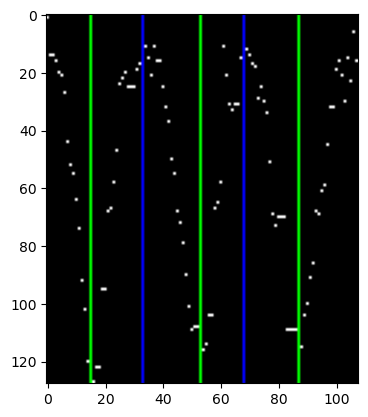

In [100]:
RV_areas = right_segmentation_masks.sum(axis=(1,2))
RV_area_image = np.zeros((128, num_frames, 3), dtype=np.uint8)

min_area, max_area = RV_areas.min(), RV_areas.max()
trim_min = sorted(RV_areas)[round(len(RV_areas) ** 0.05)]
trim_max = sorted(RV_areas)[round(len(RV_areas) ** 0.95)]
trim_range = trim_max - trim_min
diastoles = scipy.signal.find_peaks(RV_areas, distance=20, prominence=(0.50 * trim_range))[0]
systoles = scipy.signal.find_peaks(-RV_areas, distance=20, prominence=(0.50 * trim_range))[0]

RV_areas = np.uint8((RV_areas - min_area) / (max_area - min_area) * 127)

for i, area in enumerate(RV_areas):
    RV_area_image[127-area, i] = WHITE.tolist()

for s in systoles:
    RV_area_image[:, s] = GREEN

for d in diastoles:
    RV_area_image[:, d] = RED

plt.imshow(RV_area_image)

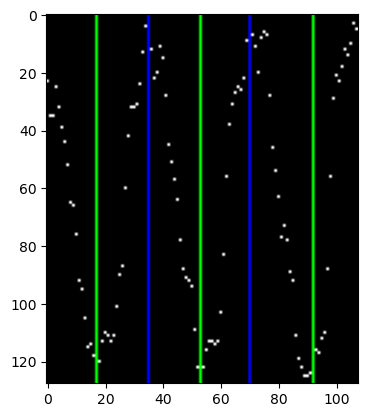

In [101]:
LV_areas = left_segmentation_masks.sum(axis=(1,2))
LV_area_image = np.zeros((128, num_frames, 3), dtype=np.uint8)

min_area, max_area = LV_areas.min(), LV_areas.max()
trim_min = sorted(LV_areas)[round(len(LV_areas) ** 0.05)]
trim_max = sorted(LV_areas)[round(len(LV_areas) ** 0.95)]
trim_range = trim_max - trim_min
diastoles = scipy.signal.find_peaks(LV_areas, distance=20, prominence=(0.50 * trim_range))[0]
systoles = scipy.signal.find_peaks(-LV_areas, distance=20, prominence=(0.50 * trim_range))[0]

LV_areas_normalised = np.uint8((LV_areas - min_area) / (max_area - min_area) * 127)

for i, area in enumerate(LV_areas_normalised):
    LV_area_image[127-area, i] = WHITE.tolist()

for s in systoles:
    LV_area_image[:, s] = GREEN

for d in diastoles:
    LV_area_image[:, d] = RED

plt.imshow(LV_area_image)

## Classify LV and RV by estimated ejection fraction
Note we're obviously only using the 2D images, so approximating ESV and EDV with 
areas, not volumes!

In [102]:
# Note we're assuming male patients for simplicity right now, but of course, 
# these exact numbers depend on the demographics!
LV_EF_classifications = {
    "normal": (52, 72),
    "mildy abnormal": (41, 51),
    "moderately abnormal": (30, 40),
    "severely abnormal": (0, 30),
    "unclassified (very high)": (73, 100)
}
# Based on https://www.ahajournals.org/doi/10.1161/CIRCEP.116.004067#:~:text=RV%20dysfunction%20was%20defined%20as,range%2C%207%E2%80%9378%25).
RV_EF_classifications = {
    "abnormal": (0, 45),
    "normal": (46, 100)
}

def classify_ejection_fraction(EF: float, classifications: dict) -> str:
    # Need to round EF to nearest integer (as percentage) for comparisons
    EF = round(EF * 100)
    for classification, (lower, upper) in classifications.items():
        if lower <= EF <= upper:
            return classification

for areas, name, classifications in zip((LV_areas, RV_areas), ("LV", "RV"), (LV_EF_classifications, RV_EF_classifications)):
    ave_sys_area = np.mean(areas[systoles])
    std_sys_area = np.std(areas[systoles])
    ave_dia_area = np.mean(areas[diastoles])
    std_dia_area = np.std(areas[diastoles])
    print(f"{name} average areas: EDV={int(ave_dia_area)} ± {int(std_dia_area)}; ESV={int(ave_sys_area)} ± {int(std_sys_area)}   [pixels squared]")
    EF = (ave_dia_area - ave_sys_area) / ave_dia_area
    EF_classification = classify_ejection_fraction(EF, classifications)
    print(f"{name} EF = {EF*100:.2f}% ({EF_classification})\n")

LV average areas: EDV=1412 ± 6; ESV=893 ± 5   [pixels squared]
LV EF = 36.76% (moderately abnormal)

RV average areas: EDV=112 ± 0; ESV=18 ± 16   [pixels squared]
RV EF = 83.70% (normal)



## Plot distributions of LV and RV area
We would expect the LV distribution to be relatively smooth, and the RV to be a little choppy just due to its poorer segmentation quality.

5.0 14.0


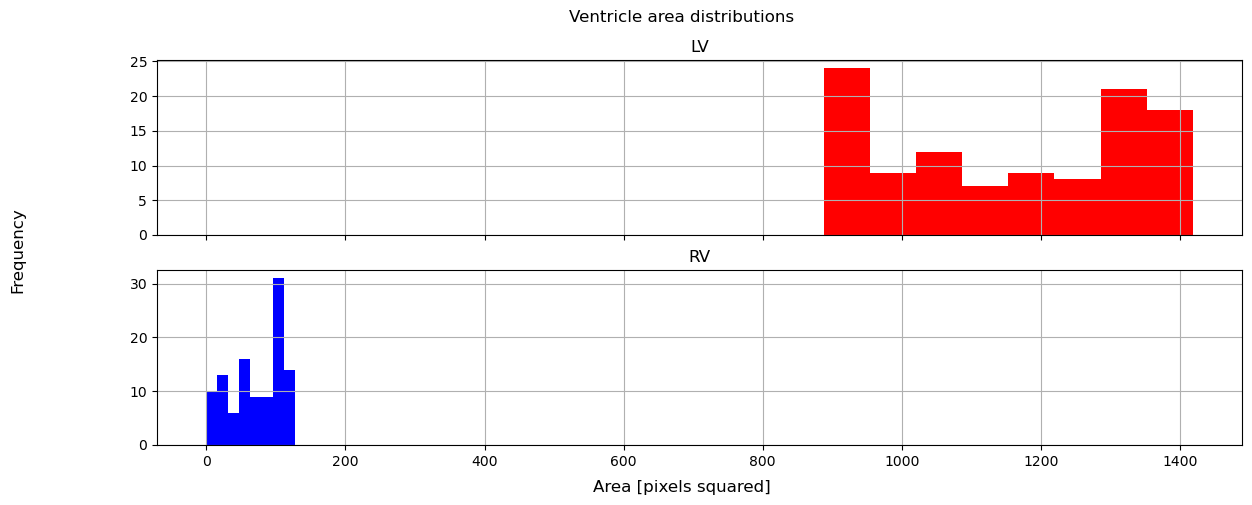

In [110]:
fig, axes = plt.subplots(2, sharex=True, figsize=(14, 5))
fig.suptitle("Ventricle area distributions")
fig.supxlabel("Area [pixels squared]")
fig.supylabel("Frequency")

for i, (areas, name, color) in enumerate(zip((LV_areas, RV_areas), ("LV", "RV"), ("red", "blue"))):
    bins = np.histogram_bin_edges(areas, bins="auto")
    axes[i].hist(areas, bins=bins, color=color)
    axes[i].set_title(name)
    axes[i].grid()

## Display segmentation (and whatever else we want) on top of original ultrasound video

In [104]:
WINDOW = "Mask"
annulus = (14, 75)
TAPSE_thresh = 40

def onclick(event, x, y, flags=None, param=None):
    global annulus, TAPSE_cross_sections, TAPSE_line, TAPSE
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked @ ({x}, {y})")
        annulus = (int(x), int(y))
        TAPSE_line, TAPSE_cross_sections = get_TAPSE(annulus=annulus)

        # Find intersection of TAPSE line with valve cutoff line to get ballpark
        # estimate of annulus height within the TAPSE graph. Crop TAPSE to only
        # the estimated annulus region
        valve_cutoff_points = valve_cutoff_points_list[0]
        shared_pixels = [p for p in valve_cutoff_points if p in TAPSE_line]
        if len(shared_pixels) > 0:
            shared_pixel = shared_pixels[0]
            intersection_index = TAPSE_line.index(shared_pixel)
            TAPSE_cross_sections = TAPSE_cross_sections[intersection_index-20:intersection_index+20]

        # Denoise and threshold TAPSE graph to make it easier to analyse
        TAPSE_cross_sections = cv2.fastNlMeansDenoising(TAPSE_cross_sections,None,30,7,21)
        TAPSE_cross_sections[TAPSE_cross_sections < TAPSE_thresh] = 0

        # Find peaks and troughs of this TAPSE graph
        TAPSE_cross_sections_mask = TAPSE_cross_sections > 0
        TAPSE_systoles = [np.argmax(TAPSE_cross_sections_mask[:, s]) for s in systoles]
        TAPSE_diastoles = [np.argmax(TAPSE_cross_sections_mask[:, d]) for d in diastoles]

        TAPSE_cross_sections = cv2.cvtColor(TAPSE_cross_sections, cv2.COLOR_GRAY2BGR)

        # Highlight the pixels used to determine the TAPSE values
        for s, t in zip(systoles, TAPSE_systoles):
            TAPSE_cross_sections[t, s] = GREEN.tolist()
        for d, t in zip(diastoles, TAPSE_diastoles):
            TAPSE_cross_sections[t, d] = RED.tolist()

        # Determine final TAPSE estimate
        TAPSE = abs(np.mean(TAPSE_systoles) - np.mean(TAPSE_diastoles))
        TAPSE_ave_s = int(np.mean(TAPSE_systoles))
        TAPSE_ave_d = int(np.mean(TAPSE_diastoles))
        p1 = np.array(TAPSE_line[TAPSE_ave_s])
        p2 = np.array(TAPSE_line[TAPSE_ave_d])
        TAPSE = np.linalg.norm(p1 - p2)


def onchange(new_thresh):
    global TAPSE_thresh
    TAPSE_thresh = new_thresh
    onclick(cv2.EVENT_LBUTTONDOWN, *annulus)

cv2.namedWindow(WINDOW, cv2.WINDOW_NORMAL)
cv2.namedWindow("TAPSE", cv2.WINDOW_NORMAL)
cv2.namedWindow("LV area", cv2.WINDOW_NORMAL)
cv2.namedWindow("RV area", cv2.WINDOW_NORMAL)
cv2.setMouseCallback(WINDOW, onclick)
cv2.createTrackbar("slider", "TAPSE", TAPSE_thresh, 255, onchange)

i = 0
is_playing = True

min_y = 1000
max_y = -1000

# Manually call onclick() to initialise some variables
onclick(cv2.EVENT_LBUTTONDOWN, *annulus)
try:
    while True:
        if i >= num_frames:
            i = 0
            print("Video looped!")
        elif i < 0:
            i = num_frames - 1

        # Copy data for this particular frame
        frame = echonet_video[i].copy()
        left_segmentation_mask = left_segmentation_masks[i].copy()
        left_segmentation = left_segmentations[i].copy()
        right_segmentation_mask = right_segmentation_masks[i].copy()
        right_segmentation = right_segmentations[i].copy()

        # this_area = RV_areas[i]
        # LV_line = LV_lines[i]
        # RV_line = RV_lines[i]
        LV_box = LV_boxes[i]
        # LV_rect = LV_rects[i]
        # LV_angle = get_angle(LV_rect)
        # print(f"{LV_angle:.2f}: {LV_box}")
        # RV_box = RV_boxes[i]
        # RV_box = get_min_area_box(right_segmentation)
        # RV_rect = get_min_area_rect(right_segmentation)
        # RV_angle = get_angle(RV_rect)
        # print(f"{RV_angle:.2f}: {RV_box}: {RV_rect}")

        RV_box = get_min_area_box(right_segmentation)
        # Add any drawings to the ultrasound here
        frame[left_segmentation_mask] = RED
        frame[right_segmentation_mask] = BLUE

        # cv2.drawContours(frame,[RV_box],0, YELLOW.tolist())

        # LV_box = get_min_area_box(left_segmentation)
        cv2.drawContours(frame,[LV_box],0, YELLOW.tolist())
        # clip_and_draw_line(frame, LV_septum_border_cutoff_points_list[i], ORANGE.tolist())
        # clip_and_draw_line(frame, valve_cutoff_points_list[i], ORANGE.tolist())
        # clip_and_draw_line(frame, apex_cutoff_points_list[i], ORANGE.tolist())
        # clip_and_draw_line(frame, RV_lines[i], MAGENTA.tolist())
        
        clip_and_draw_line(frame, ultrasound_left_line, GREEN.tolist())
        clip_and_draw_line(frame, ultrasound_right_line, GREEN.tolist())
        # cv2.line(frame, np.intp(LV_line[0]), np.intp(LV_line[1]), ORANGE.tolist())
        # cv2.line(frame, np.intp(RV_line[0]), np.intp(RV_line[1]), RED.tolist())

        # RV_rect = RV_rects[i]
        # bl, tl, br, tr = find_corner(RV_rect, BOTTOM_LEFT), find_corner(RV_rect, TOP_LEFT), find_corner(RV_rect, BOTTOM_RIGHT), find_corner(RV_rect, TOP_RIGHT)
        # frame[br[1], br[0]] = RED
        # cv2.drawContours(frame,[LV_box],0, YELLOW.tolist())
        # bl, tl, br, tr = find_corner(LV_rect, BOTTOM_LEFT), find_corner(LV_rect, TOP_LEFT), find_corner(LV_rect, BOTTOM_RIGHT), find_corner(LV_rect, TOP_RIGHT)
        # frame[bl[1], bl[0]] = RED
        # frame[tl[1], tl[0]] = GREEN
        # print(LV_rect, LV_box)

        # # Draw cutoff lines for debugging purposes
        # LV_septum_border_cutoff_points = LV_septum_border_cutoff_points_list[i]
        # clip_and_draw_line(frame, LV_septum_border_cutoff_points, ORANGE.tolist())
        # apex_cutoff_points = apex_cutoff_points_list[i]
        # clip_and_draw_line(frame, apex_cutoff_points, GREEN.tolist())
        valve_cutoff_points = valve_cutoff_points_list[i]
        clip_and_draw_line(frame, valve_cutoff_points, MAGENTA.tolist())

        TAPSE_cross_sections_copy = TAPSE_cross_sections.copy()
        TAPSE_cross_sections_copy[:, i] = BLUE.tolist()
        TAPSE_height = TAPSE_cross_sections_copy.shape[0]
        cv2.putText(TAPSE_cross_sections_copy, f"TAPSE: {TAPSE:.2f}", org=(5,TAPSE_height-5), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=RED.tolist())
        cv2.imshow("TAPSE", TAPSE_cross_sections_copy)
        # clip_and_draw_line(frame, TAPSE_line, RED.tolist())
        
        LV_area_image_copy = LV_area_image.copy()
        LV_area_image_copy[:, i] = BLUE.tolist()
        cv2.imshow("LV area", LV_area_image_copy)

        RV_area_image_copy = RV_area_image.copy()
        RV_area_image_copy[:, i] = BLUE.tolist()
        cv2.imshow("RV area", RV_area_image_copy)

        # top_border = np.zeros((frame_height // 8, frame_width, 3), dtype=frame.dtype)
        # top_border[:, :] = np.expand_dims(LIGHT_GREY, (0, 1))
        # cv2.putText(top_border, f"Frame {i+1}/{num_frames}", org=(5,10), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25, color=RED.tolist())
        # frame = np.concatenate([top_border, frame], axis=0)
        
        cv2.imshow(WINDOW, frame)

        keypress = cv2.waitKey(50) & 0xFF
        if keypress == ord('q'):
            break
        elif keypress == ord(' '):
            is_playing = not is_playing
        elif keypress == ord('a'):
            i -= 1
        elif keypress == ord('d'):
            i += 1
        else:
            if is_playing:
                i += 1
finally:
    cv2.destroyAllWindows() 

Clicked @ (14, 75)
Clicked @ (14, 75)


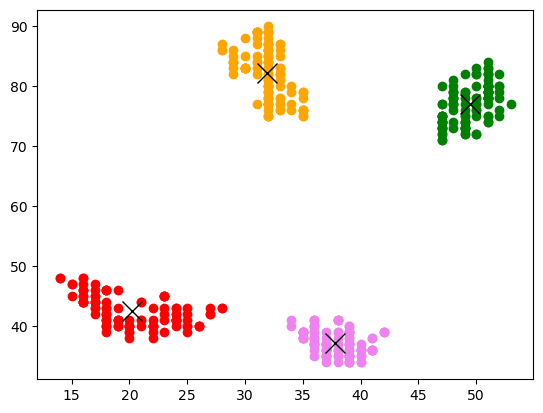

In [105]:
from sklearn.cluster import KMeans

RV_boxes = np.array([get_min_area_box(right_segmentation) for right_segmentation in right_segmentations if get_min_area_box(right_segmentation) is not None])
RV_points = RV_boxes.reshape((-1, RV_boxes.shape[-1]))

kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(RV_points)

colours = ["red", "green", "violet", "orange"]
RV_ave_corners = []

for i, colour in enumerate(colours):
    points = RV_points[kmeans.labels_ == i]
    xs, ys = zip(*points)
    centre_x, centre_y = np.mean(xs), np.mean(ys)
    RV_ave_corners.append((centre_x, centre_y))
    plt.scatter(xs, ys, color=colour)
    plt.plot([centre_x], [centre_y], color="black", marker="x", markersize=15)

plt.show()